# Development and training of Intelligent Decision Support System for Stroke management and prediction
by:
- Felix Mühlenberend
- Nuray Agaoglu
- Ana Zanko
- Max de Visser

**Date**: 04/01/2024

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

rs = 42 # random state
torch.manual_seed(rs)  # torch random state

# Dataset overview

In [2]:
df_raw = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
df_raw = df_raw.drop(columns=['id'])
display(df_raw.head())
print("Dataset statistics:")
display(df_raw.describe())

plt.show()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Dataset statistics:


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


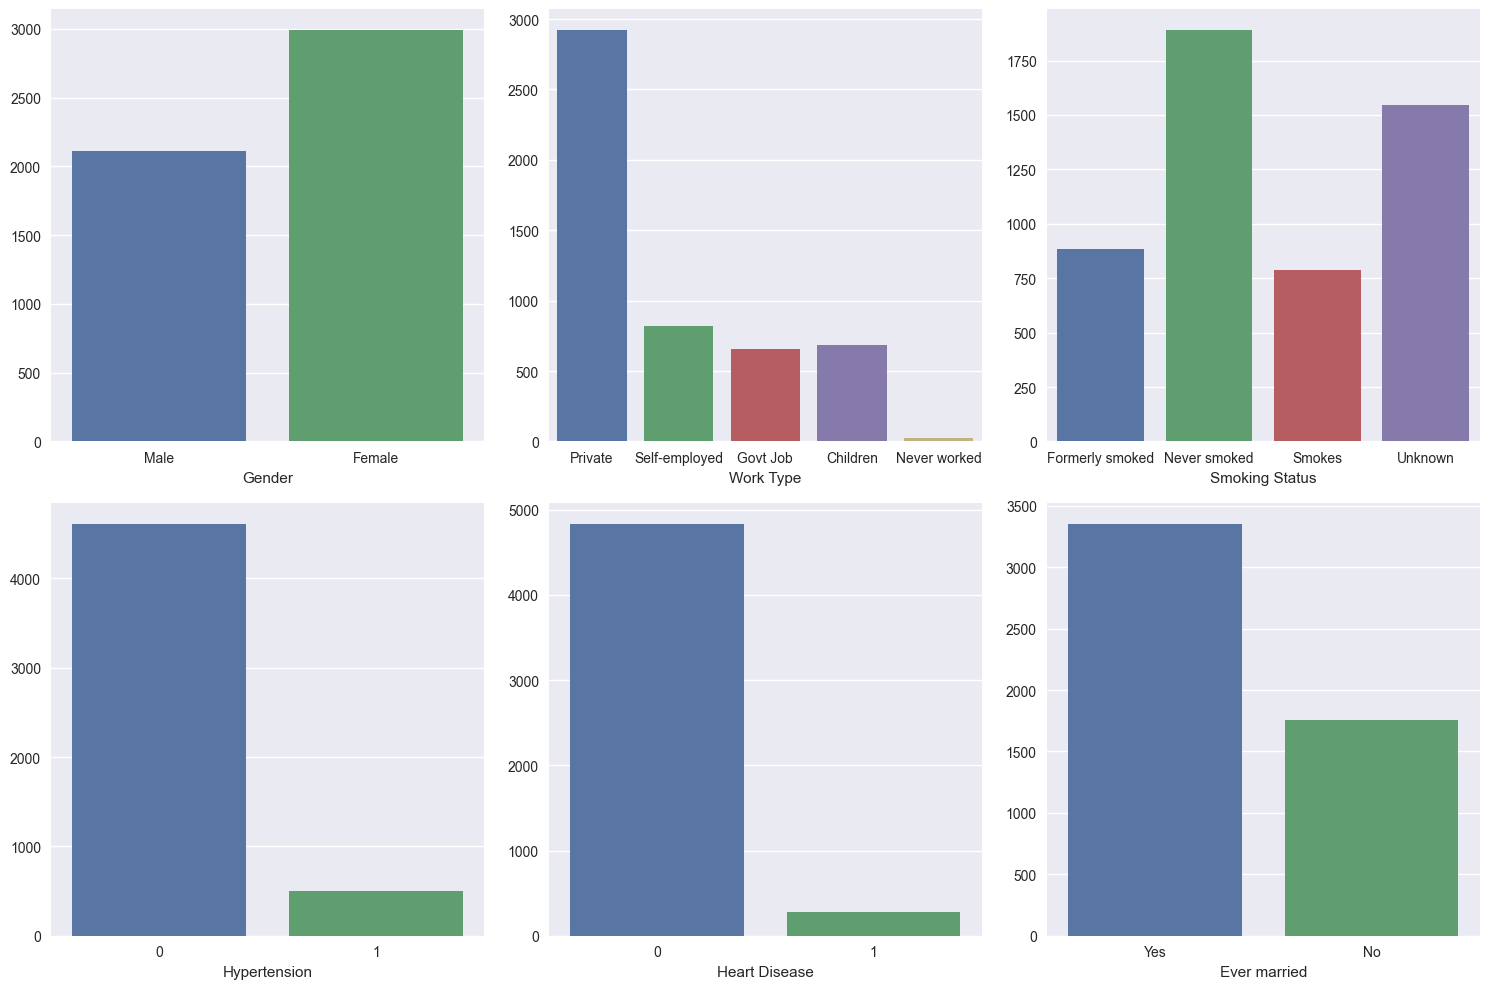

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
df_raw.iloc[3116, 0] = "Female"
sns.countplot(data=df_raw, x="gender", ax=axs[0, 0])
axs[0,0].set_xlabel("Gender")
axs[0,0].set_ylabel("")

sns.countplot(data=df_raw, x="work_type", ax=axs[0, 1])
axs[0,1].set_xlabel("Work Type")
axs[0,1].set_xticks([0,1,2,3,4], ["Private", "Self-employed", "Govt Job", "Children", "Never worked"])
axs[0,1].set_ylabel("")

sns.countplot(data=df_raw, x="smoking_status", ax=axs[0, 2])
axs[0,2].set_xlabel("Smoking Status")
axs[0,2].set_xticks([0,1,2,3], ["Formerly smoked", "Never smoked", "Smokes", "Unknown"])
axs[0,2].set_ylabel("")

sns.countplot(data=df_raw, x="hypertension", ax=axs[1, 0])
axs[1,0].set_xlabel("Hypertension")
axs[1,0].set_ylabel("")

sns.countplot(data=df_raw, x="heart_disease", ax=axs[1, 1])
axs[1,1].set_xlabel("Heart Disease")
axs[1,1].set_ylabel("")

sns.countplot(data=df_raw, x="ever_married", ax=axs[1, 2])
axs[1,2].set_xlabel("Ever married")
axs[1,2].set_ylabel("")

plt.tight_layout()
plt.savefig("plots/feature_distribution.png")
plt.show()

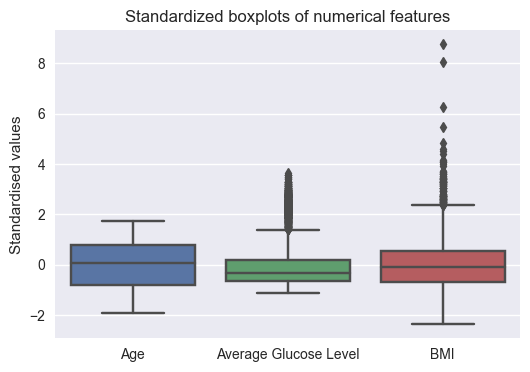

In [4]:
plt.figure(figsize=(6, 4))
scaler = StandardScaler() # first standardize the data to make the boxplots comparable
ax = sns.boxplot(data=scaler.fit_transform(df_raw[['age', 'avg_glucose_level', 'bmi']]))
ax.set_xticklabels(['Age', 'Average Glucose Level', 'BMI'])
plt.title("Standardized boxplots of numerical features")
plt.ylabel("Standardised values")
plt.savefig("plots/boxplots.png", dpi=300)
plt.show()

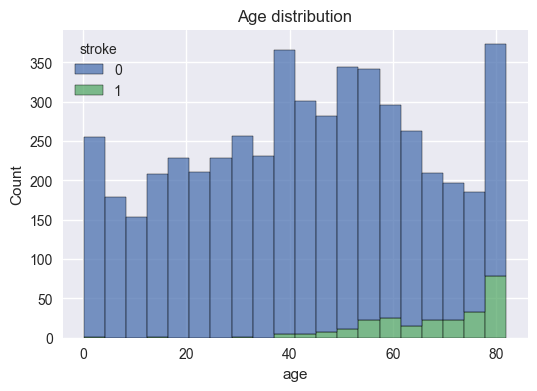

In [5]:
plt.figure(figsize=(6, 4))
sns.histplot(df_raw, x="age", hue="stroke", multiple="stack")
plt.title("Age distribution")
plt.show()

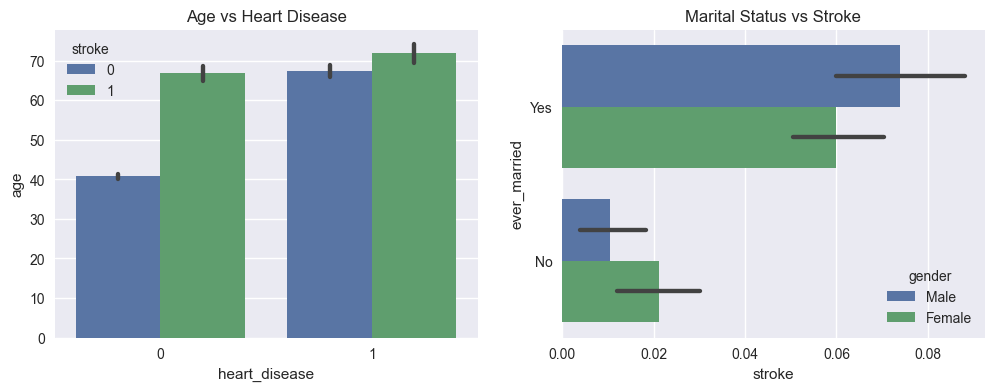

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=df_raw, x="heart_disease", y="age", hue="stroke", ax=axes[0])
axes[0].set_title("Age vs Heart Disease")

df_raw.iloc[3116, 0] = "Female"
sns.barplot(data=df_raw, x="stroke", y="ever_married", hue="gender", ax=axes[1])
axes[1].set_title("Marital Status vs Stroke")

plt.show()

# Preprocessing

In [7]:
df_raw = pd.read_csv("data/healthcare-dataset-stroke-data.csv")

# remove ID column
df_processed = df_raw.drop(columns=['id'])

# Change only record with gender "other" to majority
df_processed.iloc[3116, 0] = "Female"

# remove records with too low age
df_processed_baseline = df_processed[df_processed.age >= 10] # baseline dataset with limited further processing
# impute missing values for BMI using median for baseline dataset:
df_processed_baseline['bmi'].fillna(df_processed_baseline['bmi'].median(), inplace=True)

### DEALING WITH MISSING VALUES ###
# Perform Undersampling to account for data imbalance
# randomly remove 80% of the non-stroke instances
df_processed = df_processed_baseline.drop(df_processed_baseline.query("stroke == 0").sample(frac=.8).index)

# Remove extreme values for BMI
df_processed = df_processed[df_processed.bmi < 70]

# imputing missing values for BMI using KNN technique
imputer = KNNImputer(n_neighbors=5)
df_processed['bmi'] = imputer.fit_transform(df_processed[['bmi']])

# Encode categorical variables as numbers
def encode_numericals(df: pd.DataFrame) -> pd.DataFrame:
    """Encodes categorical variables as numbers"""
    df_return = df.copy()
    df_return['ever_married'] = df_return['ever_married'].replace({'Yes': 1, 'No': 0})
    df_return['work_type'] = df_return['work_type'].replace({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
    df_return['Residence_type'] = df_return['Residence_type'].replace({'Urban': 1, 'Rural': 0})
    df_return['smoking_status'] = df_return['smoking_status'].replace({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 3})
    df_return['gender'] = df_return['gender'].replace({"Female": 0, "Male": 1})
    return df_return

# Encode baseline and processed datasets:
df_processed = encode_numericals(df_processed)
df_processed_baseline = encode_numericals(df_processed_baseline)

/var/folders/r8/9_x5mqbs79gbpktlgmt3lyb40000gn/T/ipykernel_3047/3093771011.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed_baseline['bmi'].fillna(df_processed_baseline['bmi'].median(), inplace=True)


Distribution of classes with synthetic data:
{'not stroke': 877, 'stroke': 613}


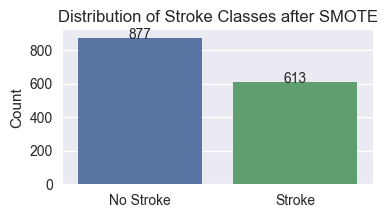

In [8]:
### DEALING WITH CLASS IMBALANCE ###
# SMOTE: oversampling using k-nearest neighbors to create synthetic data
oversampling_ratio = 0.7 # can only be used for binary classification
smote = SMOTE(sampling_strategy=oversampling_ratio, k_neighbors=5, random_state=rs)
X = df_processed.drop(columns=['stroke'])
y = df_processed['stroke']
X_resampled, y_resampled = smote.fit_resample(X, y)
df_processed = pd.concat([X_resampled, y_resampled], axis=1)

unique, counts = np.unique(df_processed.stroke, return_counts=True)
print("Distribution of classes with synthetic data:")
print(dict(zip(("not stroke", "stroke"), counts)))

# Stroke distribution after SMOTE
plt.figure(figsize=(4, 2))
sns.countplot(data=df_processed, x='stroke')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])  # Change x labels
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2, p.get_height() + 15), ha='center', va='center')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of Stroke Classes after SMOTE')
plt.savefig('plots/stroke_distribution_after_smote.png', dpi=300)
plt.show()

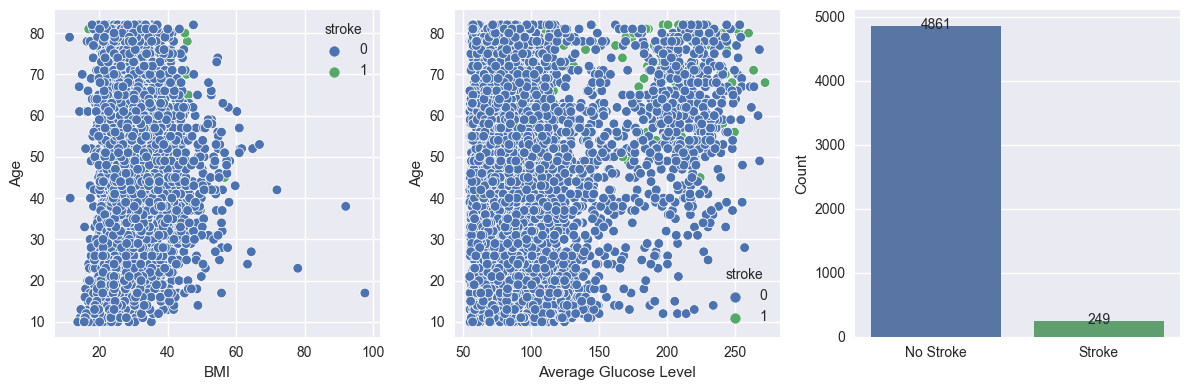

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(data=df_raw[df_raw["age"] >= 10], x="bmi", y="age", hue="stroke", ax=axs[0])
sns.scatterplot(data=df_raw[df_raw["age"] >= 10], x="avg_glucose_level", y="age", hue="stroke", ax=axs[1])
axs[0].set_xlabel("BMI")
axs[0].set_ylabel("Age")
axs[1].set_xlabel("Average Glucose Level")
axs[1].set_ylabel("Age")

sns.countplot(data=df_raw, x='stroke', ax=axs[2])
axs[2].set_xticks([0, 1], ['No Stroke', 'Stroke'])
axs[2].set_xlabel('')
axs[2].set_ylabel('Count')
for p in axs[2].patches:
    axs[2].annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2, p.get_height() + 15), ha='center', va='center')

plt.tight_layout()
plt.savefig("plots/age_vs_glucose_level.png", dpi=300)
plt.show()

Text(0.5, 1.0, 'Pearson correlation')

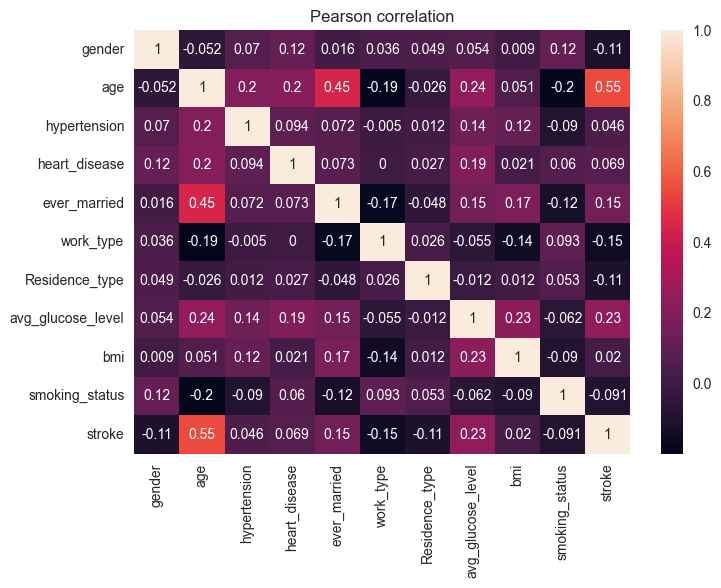

In [10]:
# make correlation plot
corr = df_processed.corr("pearson").round(3)
sns.heatmap(corr, annot=True)
plt.title("Pearson correlation")

# Model Training

## Final Data preparation for training

In [11]:
# feature stanardisation for numerical features
scaler = StandardScaler()
df_processed[['age','avg_glucose_level', 'bmi']] = scaler.fit_transform(df_processed[['age', 'avg_glucose_level', 'bmi']])

# one hot encoding to neutralise ordinality
categorical_variables = ['work_type', 'smoking_status']
df_processed = pd.get_dummies(df_processed, columns=categorical_variables, drop_first=True) # drop_first to avoid dummy variable trap.

# do drop first on gender since it is binary
# we do not want the model to discrimate towards genders
df_processed = pd.get_dummies(df_processed, columns=['gender'], drop_first=False)

df_processed.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_1,work_type_2,work_type_3,work_type_4,smoking_status_1,smoking_status_2,smoking_status_3,gender_0,gender_1
0,0.589403,0,1,1,1,2.095730,0.979797,1,0,0,0,0,1,0,0,0,1
1,0.294778,0,0,1,0,1.599621,-0.178784,1,1,0,0,0,0,0,0,1,0
2,1.227756,0,1,1,0,-0.204397,0.370800,1,0,0,0,0,0,0,0,0,1
3,-0.294471,0,0,1,1,1.019202,0.653018,1,0,0,0,0,0,1,0,1,0
4,1.178652,1,0,1,0,1.073347,-0.891756,1,1,0,0,0,0,0,0,1,0


## Random Forest model

Random Forest model trained on non-preprocessed data:
Accuracy:  0.9568965517241379


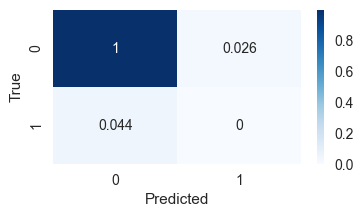

F1-score:  0.0
Precision:  0.0
Recall:  0.0
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       0.00      0.00      0.00        39

    accuracy                           0.96       928
   macro avg       0.48      0.50      0.49       928
weighted avg       0.92      0.96      0.94       928

Random Forest model trained on preprocessed data:
Accuracy:  0.8355704697986577


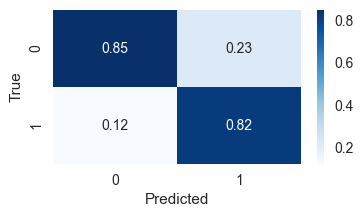

F1-score:  0.7999999999999999
Precision:  0.784
Recall:  0.8166666666666667
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       178
           1       0.78      0.82      0.80       120

    accuracy                           0.84       298
   macro avg       0.83      0.83      0.83       298
weighted avg       0.84      0.84      0.84       298



In [14]:
def train_rf_model(dataset, plot_name, split_ratio: float = 0.2):
    # fit a random forest classifier
    X = dataset.drop(columns=["stroke"])
    y = dataset["stroke"]
    # split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio)

    clf = RandomForestClassifier(
        n_estimators=100, # number of trees in the forest
        criterion="gini", # function to measure the quality of a split
        max_depth=None,
        max_features="sqrt", # maximum number of features to consider at each split
        min_samples_split=2, # minimum number of samples required to split an internal node
        min_samples_leaf=1, # minimum number of samples required to be at a leaf node
    )
    clf.fit(X_train, y_train)

    # make predictions
    y_pred = clf.predict(X_test)

    # evaluate the model

    print("Accuracy: ", accuracy_score(y_test, y_pred))

    # confusion matrix
    plt.figure(figsize=(4, 2))
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix = cf_matrix / cf_matrix.astype(float).sum(axis=1)
    sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    if plot_name:
        plt.savefig("plots/" + plot_name + ".png", dpi=300)
    plt.show()

    print("F1-score: ", f1_score(y_test, y_pred))
    print("Precision: " ,precision_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))

    print(classification_report(y_test, y_pred))
    return clf


# model train on non-preprocessed data (highly imbalanced data)
print("Random Forest model trained on non-preprocessed data:")
clf_baseline = train_rf_model(df_processed_baseline, plot_name="baseline_confusion_matrix")

# model trained on preprocessed data
print("Random Forest model trained on preprocessed data:")
clf = train_rf_model(df_processed, plot_name="preprocessed_confusion_matrix")

# Multilayer perceptron

In [15]:
# split data into train and test sets
X = df_processed.drop(columns=['stroke'])
y = df_processed['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

# convert data to tensors for training
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float)

In [16]:
# simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# hyperparameters
n_features = X_train_tensor.shape[1]
input_size = n_features
hidden_size = n_features * 2
output_size = 1

# instantiate model
model = SimpleNN(input_size, hidden_size, output_size)

# loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # Forward pass:
    outputs = model(X_train_tensor)
    # Compute the loss:
    loss = criterion(outputs, y_train_tensor)
    # Backward pass and optimization:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print loss every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        # calculate evaluation metrics:
        outputs = outputs.detach().numpy()
        outputs = np.where(outputs >= 0.5, 1, 0)
        print(f"Accuracy: {accuracy_score(y_train, outputs):.4f}")
        print(f"F1-score: {f1_score(y_train, outputs)}:.4f")
        print(f"Precision: {precision_score(y_train , outputs)}:.4f")
        print(f"Recall: {recall_score(y_train, outputs)}:.4f")
        print("")

Epoch [500/5000], Loss: 0.5389
Accuracy: 0.7289
F1-score: 0.6261558784676354:.4f
Precision: 0.716012084592145:.4f
Recall: 0.5563380281690141:.4f

Epoch [1000/5000], Loss: 0.5231
Accuracy: 0.7366
F1-score: 0.6487867177522348:.4f
Precision: 0.711484593837535:.4f
Recall: 0.596244131455399:.4f

Epoch [1500/5000], Loss: 0.5185
Accuracy: 0.7395
F1-score: 0.653061224489796:.4f
Precision: 0.7150837988826816:.4f
Recall: 0.6009389671361502:.4f

Epoch [2000/5000], Loss: 0.5112
Accuracy: 0.7404
F1-score: 0.6633540372670808:.4f
Precision: 0.7044854881266491:.4f
Recall: 0.6267605633802817:.4f

Epoch [2500/5000], Loss: 0.5112
Accuracy: 0.7452
F1-score: 0.6649874055415617:.4f
Precision: 0.717391304347826:.4f
Recall: 0.6197183098591549:.4f

Epoch [3000/5000], Loss: 0.5104
Accuracy: 0.7481
F1-score: 0.6606451612903225:.4f
Precision: 0.7335243553008596:.4f
Recall: 0.6009389671361502:.4f

Epoch [3500/5000], Loss: 0.5044
Accuracy: 0.7471
F1-score: 0.6666666666666666:.4f
Precision: 0.7213114754098361:.4f
Re

Accuracy:  0.7388392857142857
F1-score:  0.7220902612826603
Precision:  0.6523605150214592
Recall:  0.8085106382978723


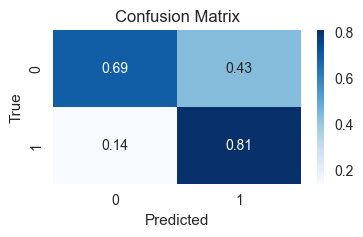

In [17]:
# Evaluate the model on the test set:
predicted_probs = model(X_test_tensor)
predicted_labels = (predicted_probs > 0.5).float()
predicted_labels = predicted_labels.detach().numpy()
print("Accuracy: ", accuracy_score(y_test, predicted_labels))
print("F1-score: ", f1_score(y_test, predicted_labels))
print("Precision: ", precision_score(y_test , predicted_labels))
print("Recall: ", recall_score(y_test, predicted_labels))

# confusion matrix
plt.figure(figsize=(4, 2))
cf_matrix = confusion_matrix(y_test, predicted_labels)
cf_matrix = cf_matrix / cf_matrix.astype(float).sum(axis=1)
sns.heatmap(cf_matrix, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/nn_confusion_matrix.png", dpi=300)
plt.show()